In [1]:
import pandas as pd
import numpy as np

PARTITION_DIR = 's3://customer-churn-spark'

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [24]:
def retrieve_data(partition_num, label_type='MS-31'):
    fm = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory=False).\
            drop(columns = ['label', 'days_to_churn', 'churn_date']).rename(columns = {'time': 'cutoff_time'})
    labels = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_labels.csv', low_memory=False)
    feature_matrix = fm.merge(labels, on = ['msno', 'cutoff_time'], how = 'inner')
    return feature_matrix

import random
random.seed(50)

from multiprocessing import Pool


def train_test_data(fms_to_get=50, split_date=pd.datetime(2016, 6, 1)):
    
    # Set number of train and testing feature matrices
    fms_to_get = 50

    # Choose random sample of partitions
    ps = random.sample(list(range(900)), fms_to_get)
    
    pool = Pool(6)
    # Retrieve feature matrices from S3
    fms = []
    for i, r in enumerate(pool.imap_unordered(retrieve_data, ps)):
        print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
        if r.shape[1] == 253:
            fms.append(r)
    pool.close()
    pool.join()

    # Join together and drop rows with unknown label
    feature_matrix = pd.concat(fms)
    feature_matrix = feature_matrix[~feature_matrix['label'].isna()]
    
    # Drop rows with no previous transactions
    feature_matrix = feature_matrix[~feature_matrix['TIME_SINCE_LAST(transactions.transaction_date)'].isna()]
    # Remove outliers
    feature_matrix = feature_matrix[feature_matrix['TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)'] < 10]
    feature_matrix.drop(columns = [c for c in ['churn', 'days_to_next_churn', 
                                               'churn_date'] if c in feature_matrix],
                        inplace = True)
    print(f'Original feature matrix shape: {feature_matrix.shape}')

    # Convert boolean columns
    feature_matrix = feature_matrix.replace({'False': 0, 'True': 1})
    bool_cols = [c for c in feature_matrix if 'ALL' in c or ('WEEKEND' in c and 'PERCENT_TRUE' not in c)]
    for c in bool_cols:
        feature_matrix[c] = feature_matrix[c].astype(float)
    
    # Missing values
    threshold = 0.9
    missing_pct = feature_matrix.isnull().sum() / len(feature_matrix)
    to_drop = list((missing_pct[missing_pct > threshold]).index)
    to_drop = [x for x in to_drop if x != 'days_to_churn']
    print(f'There are {len(to_drop)} columns to drop with more than {threshold} missing values.')
    feature_matrix.drop(columns = to_drop, inplace = True)
    
    # One unique value
    one_unique = feature_matrix.apply(lambda x: x.nunique() == 1, axis = 0)
    print(f'There are {len(to_drop)} columns to drop with one unique value.')
    to_drop = list(one_unique[one_unique == True].index)
    feature_matrix.drop(columns = to_drop, inplace = True)

    # Collinear features
    threshold = 0.95
    # Calculate correlations
    corr_matrix = feature_matrix.corr().abs()
    # Subset to the upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Identify names of columns with correlation above threshold
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    print(f'There are {len(to_drop)} columns to drop with correlation > {threshold}')
    feature_matrix.drop(columns = to_drop, inplace = True)
    
    # Split into training and testing
    feature_matrix['cutoff_time'] = pd.to_datetime(feature_matrix['cutoff_time'])
    test = feature_matrix[feature_matrix['cutoff_time'] >= split_date].copy()
    train = feature_matrix[feature_matrix['cutoff_time'] < split_date].copy()
    train = pd.get_dummies(train.drop(columns = ['cutoff_time', 'msno']))
    test = pd.get_dummies(test.drop(columns = ['cutoff_time', 'msno']))
    train, test = train.align(test, join = 'inner', axis = 1)
    
    # Extract labels
    y, test_y = np.array(train.pop('label')), np.array(test.pop('label'))
    y_reg, test_y_reg = np.array(train.pop('days_to_churn')), np.array(
        test.pop('days_to_churn'))
    
    # Fill in missing values
    train = train.replace({np.inf: np.nan, -np.inf: np.nan}).\
        fillna(train.median())
    test = test.replace({np.inf: np.nan, -np.inf: np.nan}).\
        fillna(train.median())
    
    return feature_matrix, train, test, y, test_y

In [25]:
fm, train, test, y, y_test = train_test_data()

Original feature matrix shape: (720855, 252)
There are 0 columns to drop with more than 0.9 missing values.
There are 0 columns to drop with one unique value.
There are 78 columns to drop with correlation > 0.95


In [26]:
pd.options.display.max_rows = 250

In [27]:
fm.isnull().sum()

msno                                                                                       0
cutoff_time                                                                                0
city                                                                                       0
bd                                                                                         0
registered_via                                                                             0
gender                                                                                385663
SUM(transactions.payment_plan_days)                                                        0
SUM(transactions.price_difference)                                                         0
SUM(transactions.planned_daily_price)                                                      0
TIME_SINCE_LAST(transactions.transaction_date)                                             0
AVG_TIME_BETWEEN(transactions.transaction_date)                       

In [29]:
churns = fm[fm['label'] == 1]
churns.describe()['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)']

count    25592.000000
mean        11.940685
std         46.736574
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        699.000000
Name: TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date), dtype: float64

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

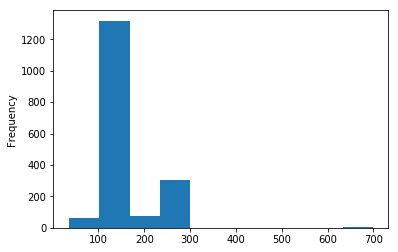

In [33]:
churns[churns['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)'] > 0]['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)'].plot.hist()

In [130]:
c = fm.groupby('msno').apply(lambda x: (x['label'] == 0).all())

In [131]:
c.head()

msno
++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=     True
++9mb7cXBm5q9SRtwUt9rBIJTBGmBELfJqmrONymKIE=    False
++FZyCl52MidGkpw1TehViPEtUMajsPhXsXrzbxWR/w=     True
++Y2Q8yzkh/D5RcA3LVIcdUrulOEI2Zwd/JOXXHAMAY=     True
++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=     True
dtype: bool

In [34]:
cancels = [f for f in churns if 'is_cancel' in f]
churns[cancels].head()

,ALL(transactions.is_cancel),LAST(transactions.is_cancel),PERCENT_TRUE(transactions.is_cancel),SUM(transactions.payment_plan_days WHERE is_cancel = 1),SUM(transactions.price_difference WHERE is_cancel = 1),ALL(transactions.is_cancel WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 1),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 1),MEAN(transactions.payment_plan_days WHERE is_cancel = 1),MEAN(transactions.plan_list_price WHERE is_cancel = 1),MEAN(transactions.actual_amount_paid WHERE is_cancel = 1),MEAN(transactions.planned_daily_price WHERE is_cancel = 1),PERCENT_TRUE(transactions.is_auto_renew WHERE is_cancel = 1),PERCENT_TRUE(transactions.is_cancel WHERE is_auto_renew = 1)
486,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
726,1.0,1.0,1.0,30.0,0.0,1.0,0.0,0.0,30.0,149.0,149.0,4.966667,1.0,1.0
863,1.0,1.0,1.0,31.0,0.0,1.0,0.0,0.0,31.0,149.0,149.0,4.806452,1.0,1.0
1044,0.0,1.0,0.5,31.0,0.0,0.0,0.0,0.0,31.0,149.0,149.0,4.806452,1.0,0.5
1092,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [35]:
churns_s = churns[churns['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)'] > 0].copy()
churns_s[cancels].describe()

,ALL(transactions.is_cancel),LAST(transactions.is_cancel),PERCENT_TRUE(transactions.is_cancel),SUM(transactions.payment_plan_days WHERE is_cancel = 1),SUM(transactions.price_difference WHERE is_cancel = 1),ALL(transactions.is_cancel WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 1),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 1),MEAN(transactions.payment_plan_days WHERE is_cancel = 1),MEAN(transactions.plan_list_price WHERE is_cancel = 1),MEAN(transactions.actual_amount_paid WHERE is_cancel = 1),MEAN(transactions.planned_daily_price WHERE is_cancel = 1),PERCENT_TRUE(transactions.is_auto_renew WHERE is_cancel = 1),PERCENT_TRUE(transactions.is_cancel WHERE is_auto_renew = 1)
count,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1736.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1624.000000,1768.000000,1768.000000
mean,0.042421,0.932127,0.215569,33.103507,-2.162896,0.047235,0.221014,0.221618,29.320451,144.071709,146.613325,4.913479,0.936652,0.226862
std,0.201604,0.251600,0.217806,18.118144,29.955079,0.212202,0.415056,0.415461,4.433138,23.859703,13.753247,0.330335,0.243657,0.225735
min,0.000000,0.000000,0.000000,0.000000,-149.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.300000,0.000000,0.000000
25%,0.000000,1.000000,0.076923,30.000000,0.000000,0.000000,0.000000,0.000000,30.000000,149.000000,149.000000,4.966667,1.000000,0.076923
50%,0.000000,1.000000,0.142857,30.000000,0.000000,0.000000,0.000000,0.000000,30.000000,149.000000,149.000000,4.966667,1.000000,0.142857
75%,0.000000,1.000000,0.285714,30.000000,0.000000,0.000000,0.000000,0.000000,30.000000,149.000000,149.000000,4.966667,1.000000,0.333333
max,1.000000,1.000000,1.000000,151.000000,149.000000,1.000000,1.000000,1.000000,31.000000,180.000000,180.000000,6.000000,1.000000,1.000000


In [36]:
from hashlib import md5

In [66]:
def find_customer_data(msno):
    partition = int(md5(msno.encode('utf-8')).hexdigest(), 16) % 1000
    
    transactions = pd.read_csv(f's3://customer-churn-spark/p{partition}/transactions.csv',
                               parse_dates = ['membership_expire_date', 'transaction_date'])
    subset = transactions.loc[transactions['msno'] == msno].copy()
    labels = pd.read_csv(f's3://customer-churn-spark/p{partition}/MS-31_labels.csv',
                         parse_dates = ['cutoff_time'])
    l_subset = labels.loc[labels['msno'] == msno].copy()
    
    return subset.sort_values('transaction_date'), l_subset.sort_values('cutoff_time')

In [67]:
churns_s['msno'][:5]

486     +PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=
726     UWx3ECqZiBc7AnB9PhzAA70SSvizMIdvi3H0zfl6TTc=
863     kjaOWp4F4XqTe4aUErTYKAPM531IAuzncwra8JqFOAs=
1044    3/TO8U7KaBU3dIMg9uWBs927NNtSqRbmdCwL/Nfk7Ts=
1241    Ol6UX6545AAByn+nGWUOGhfqTZWDoHC435BYb6ff2G0=
Name: msno, dtype: object

In [142]:
s, l = find_customer_data('+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=')
s
l

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
9285,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,24,30,149,149,1,2015-01-01,2015-01-01,0
2192,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,24,30,149,149,1,2015-02-01,2015-01-29,0
14921,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,24,30,149,149,1,2015-03-01,2015-03-01,0
3228,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,24,30,149,149,1,2015-06-11,2015-06-30,1
9179,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,33,30,149,149,1,2015-06-11,2015-06-30,0
17503,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,33,0,0,149,1,2015-06-30,2015-07-31,0
10989,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,33,0,0,149,1,2015-07-31,2015-08-31,0
13723,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,33,0,0,149,1,2015-08-31,2015-09-30,0
12093,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,33,0,0,149,1,2015-09-30,2015-10-31,0
97,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,33,0,0,149,1,2015-10-31,2015-11-30,0


,msno,cutoff_time,label,days_to_churn,churn_date
249,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,NaN,32.0,NaN
250,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,1.0,1.0,2015-02-02
251,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,NaN,32.0,NaN
252,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02
253,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaN
254,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,NaN,NaN,NaN
255,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,NaN,NaN,NaN
256,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,NaN,NaN,NaN
257,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,NaN,NaN,NaN
258,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,NaN,NaN,NaN


In [143]:
def customer_to_label_times(customer_id, transactions, prediction_freq, churn_days, return_trans = False):
    """
    Make label times for a single customer. Returns a dataframe of labels with times, the binary label, 
    and the number of days until the next churn.
       
    Params
    --------
        customer_id (str): unique id for the customer
        transactions (dataframe): transactions dataframe for the customer
        prediction_freq (str): frequency for making predicions. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership
        return_trans (boolean): whether or not to return the transactions for analysis. Defaults to False.
        
    Return
    --------
        label_times (dataframe): a table of customer id, the cutoff times at the specified frequency, the 
                                 label for each cutoff time, the number of days until the next churn for each
                                 cutoff time, and the date on which the churn itself occurred.
        transactions (dataframe): optional dataframe of customer transactions if return_trans = True. Useful
                                  for making sure that the function performed as expected
    
       """
    
    assert(prediction_freq in ['MS', 'SMS']), "Prediction day must be either 'MS' or 'SMS'"
    assert(transactions['msno'].unique() == [customer_id]), "Transactions must be for only customer"
    
    # Make sure to sort chronalogically
    transactions.sort_values(['transaction_date', 'membership_expire_date'], inplace = True)
    
    # Create next transaction day by shifting back one transaction
    transactions['next_transaction_date'] = transactions['transaction_date'].shift(-1)
    
    # Find number of days between transaction and next
    transactions['difference_days'] = (transactions['next_transaction_date'] - 
                                       transactions['membership_expire_date']).\
                                       dt.total_seconds() / (3600 * 24)
    
    # Determine which transactions are associated with a churn
    transactions['churn'] = transactions['difference_days'] > churn_days
    
    # Find date of churn
    transactions.loc[transactions['churn'] == True, 
                     'churn_date'] = transactions.loc[transactions['churn'] == True, 
                                                      'membership_expire_date'] + pd.Timedelta(churn_days + 1, 'd')
    
    # Range for label times is from first to last transaction
    first_transaction = transactions['transaction_date'].min()
    last_transaction = transactions['transaction_date'].max()
    start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
    end_date = pd.datetime(last_transaction.year, last_transaction.month, 1)
    
    # Make label times dataframe
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_freq),
                                'msno': customer_id
                               })
    # Needed for subsetting to create label time
    label_times['next_cutoff_time'] = label_times['cutoff_time'].shift(-1)
    
    # If no churns
    if (transactions['churn'] == False).all():
        label_times['label'] = 0
        label_times['days_to_churn'] = np.nan
        label_times['churn_date'] = np.nan
        # First and last label must be unknown
        label_times.loc[label_times.index[0], 'label'] = np.nan
        label_times.loc[label_times.index[-1], 'label'] = np.nan
        if return_trans: 
            return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']], transactions
        
        return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']]
    
    # Keep track of last churn
    previous_churn_date = None
    
    # Iterate through the positive churns
    for i, row in transactions.loc[transactions['churn'] == True].iterrows():
        churn_date = row['churn_date']
        
        # Find label time associated with churn and assign label 1 and churn date
        label_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                    (label_times['next_cutoff_time'] > churn_date)].index
        label_times.loc[label_idx, 'label'] = 1
        label_times.loc[label_idx, 'churn_date'] = churn_date
        
        # Find number of days until next churn
        if not previous_churn_date:
            before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
        else:
            before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                         (label_times['cutoff_time'] > previous_churn_date)].index
        # Calculate days to next churn for all label times
        label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                     'cutoff_time']).\
                                                        dt.total_seconds() / (3600 * 24)
        previous_churn_date = churn_date
        
    label_times['next_cutoff_time'] = label_times['cutoff_time'].shift(-1)
    label_times['transaction_in_period'] = [np.any((transactions['transaction_date'] >= ct) & (transactions['transaction_date'] < nct) & (transactions['is_cancel'] == 0)) for ct, nct in zip(label_times['cutoff_time'], label_times['next_cutoff_time'])]
    label_times.loc[~(label_times['label'] == 1) & (label_times['transaction_in_period'] == True), 'label'] = 0
        
    # First and last label will always be nan
    label_times.loc[label_times.index[0], 'label'] = np.nan
    label_times.loc[label_times.index[-1], 'label'] = np.nan
    
    if return_trans:
        return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']], transactions
    
    return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']]

In [145]:
label_times, t = customer_to_label_times('+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=', s, 'MS', 31, return_trans=True)

In [146]:
label_times

,msno,cutoff_time,label,days_to_churn,churn_date
0,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,NaN,91.0,NaT
1,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,0.0,60.0,NaT
2,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,0.0,32.0,NaT
3,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02
4,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaT
5,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,0.0,NaN,NaT
6,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,0.0,NaN,NaT
7,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,0.0,NaN,NaT
8,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,0.0,NaN,NaT
9,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,0.0,NaN,NaT


In [141]:
t

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
13405,++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=,41,30,149,149,1,2016-09-15,2016-10-14,0,2016-10-14,0.0,False,NaT
19436,++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=,41,30,149,149,1,2016-10-14,2016-11-14,0,2016-11-14,0.0,False,NaT
8830,++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=,41,30,149,149,1,2016-11-14,2016-12-14,0,2016-12-14,0.0,False,NaT
14083,++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=,41,30,149,149,1,2016-12-14,2017-01-14,0,2017-01-14,0.0,False,NaT
18194,++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=,41,30,149,149,1,2017-01-14,2017-02-14,0,2017-01-23,-22.0,False,NaT
11823,++kqM73xL/v0vqbSItFKWgtEyIkW2POP4c/SEA0WZmw=,41,30,149,149,1,2017-01-23,2017-01-23,1,NaT,NaN,False,NaT


In [104]:
label_times['previous_label'] = label_times['label'].shift(1)

In [106]:
label_times.loc[~(label_times['label'] == 1) & (label_times['transaction_in_period'] == True), 'label'] = 0
label_times

,msno,cutoff_time,label,days_to_churn,churn_date,next_cutoff_time,transaction_in_period,previous_label
0,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,0.0,32.0,NaT,2015-02-01,True,NaN
1,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,1.0,1.0,2015-02-02,2015-03-01,False,NaN
2,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,0.0,32.0,NaT,2015-04-01,True,1.0
3,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02,2015-05-01,False,NaN
4,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaT,2015-06-01,False,1.0
5,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,0.0,NaN,NaT,2015-07-01,True,NaN
6,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,0.0,NaN,NaT,2015-08-01,True,NaN
7,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,0.0,NaN,NaT,2015-09-01,True,NaN
8,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,0.0,NaN,NaT,2015-10-01,True,NaN
9,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,0.0,NaN,NaT,2015-11-01,True,NaN


In [102]:
label_times

,msno,cutoff_time,label,days_to_churn,churn_date,next_cutoff_time,transaction_in_period
0,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,NaN,32.0,NaT,2015-02-01,True
1,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,1.0,1.0,2015-02-02,2015-03-01,False
2,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,NaN,32.0,NaT,2015-04-01,True
3,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02,2015-05-01,False
4,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaT,2015-06-01,False
5,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,NaN,NaN,NaT,2015-07-01,True
6,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,NaN,NaN,NaT,2015-08-01,True
7,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,NaN,NaN,NaT,2015-09-01,True
8,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,NaN,NaN,NaT,2015-10-01,True
9,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,NaN,NaN,NaT,2015-11-01,True


In [100]:
np.any((t['transaction_date'] >= label_times['cutoff_time'][0]) & (t['transaction_date'] < label_times['cutoff_time'][1]))

True

In [ ]:
= label

In [97]:
t.iloc[:, 6:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
9285,2015-01-01,2015-01-01,0,2015-03-01,59.0,True,2015-02-02
14921,2015-03-01,2015-03-01,0,2015-06-11,102.0,True,2015-04-02
3228,2015-06-11,2015-06-30,1,2015-06-11,-19.0,False,NaT
9179,2015-06-11,2015-06-30,0,2015-06-30,0.0,False,NaT
17503,2015-06-30,2015-07-31,0,2015-07-31,0.0,False,NaT
10989,2015-07-31,2015-08-31,0,2015-08-31,0.0,False,NaT
13723,2015-08-31,2015-09-30,0,2015-09-30,0.0,False,NaT
12093,2015-09-30,2015-10-31,0,2015-10-31,0.0,False,NaT
97,2015-10-31,2015-11-30,0,2015-11-30,0.0,False,NaT
18039,2015-11-30,2015-12-31,0,2015-12-31,0.0,False,NaT


In [98]:
label_times

,msno,cutoff_time,label,days_to_churn,churn_date
0,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,NaN,32.0,NaT
1,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,1.0,1.0,2015-02-02
2,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,NaN,32.0,NaT
3,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02
4,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaT
5,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,NaN,NaN,NaT
6,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,NaN,NaN,NaT
7,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,NaN,NaN,NaT
8,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,NaN,NaN,NaT
9,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,NaN,NaN,NaT


In [91]:
l.iloc[:10]

,msno,cutoff_time,label,days_to_churn,churn_date
249,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,NaN,32.0,NaN
250,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,1.0,1.0,2015-02-02
251,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,NaN,32.0,NaN
252,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02
253,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaN
254,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,NaN,NaN,NaN
255,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,NaN,NaN,NaN
256,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,NaN,NaN,NaN
257,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,NaN,NaN,NaN
258,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,NaN,NaN,NaN


In [94]:
s.iloc[:, 6:]

,transaction_date,membership_expire_date,is_cancel
9285,2015-01-01,2015-01-01,0
2192,2015-02-01,2015-01-29,0
14921,2015-03-01,2015-03-01,0
3228,2015-06-11,2015-06-30,1
9179,2015-06-11,2015-06-30,0
17503,2015-06-30,2015-07-31,0
10989,2015-07-31,2015-08-31,0
13723,2015-08-31,2015-09-30,0
12093,2015-09-30,2015-10-31,0
97,2015-10-31,2015-11-30,0


In [92]:
label_times

,msno,cutoff_time,label,days_to_churn,churn_date
0,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-01-01,NaN,32.0,NaT
1,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-02-01,1.0,1.0,2015-02-02
2,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-03-01,NaN,32.0,NaT
3,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-04-01,1.0,1.0,2015-04-02
4,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-05-01,NaN,NaN,NaT
5,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-06-01,NaN,NaN,NaT
6,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-07-01,NaN,NaN,NaT
7,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-08-01,NaN,NaN,NaT
8,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-09-01,NaN,NaN,NaT
9,+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=,2015-10-01,NaN,NaN,NaT


In [45]:
t = churns_s.loc[churns_s['msno'] == '+PjIkUqn1Q6kuljLxfm/vhVI9PwSZW9t0ahHYFQt4Wg=']

In [46]:
t['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)']

486     149.0
1633    149.0
Name: TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date), dtype: float64

In [6]:
train.shape
test.shape

(392100, 168)

(328755, 168)

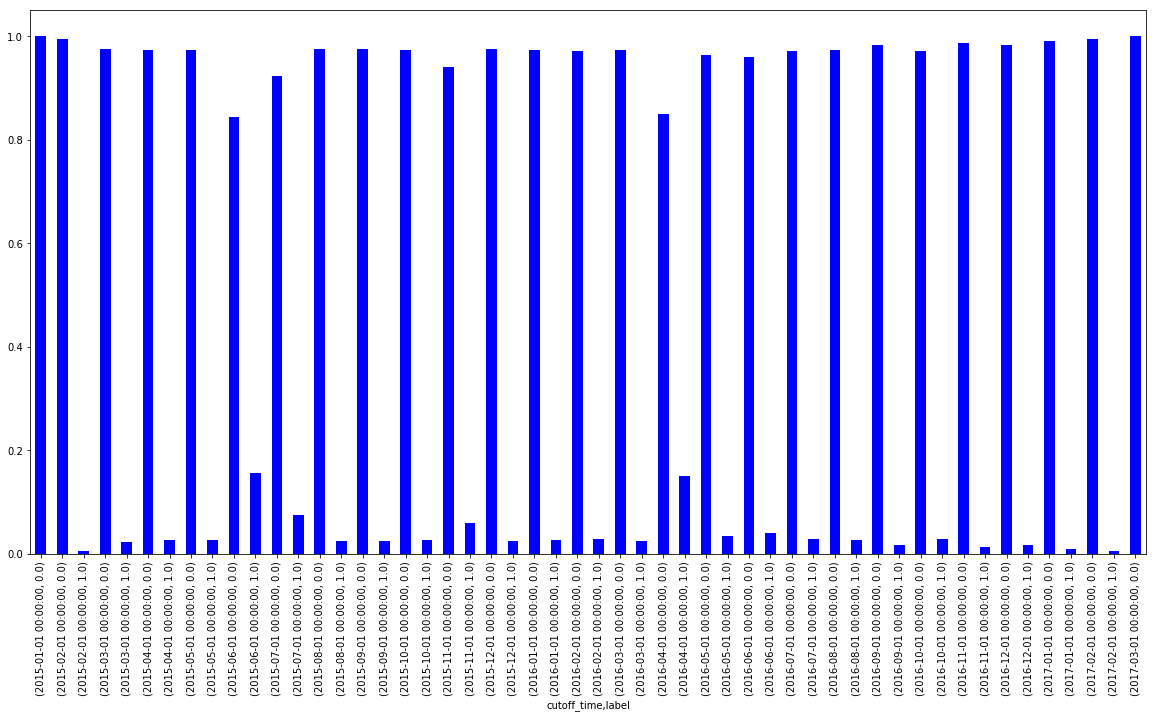

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
feature_matrix.groupby('cutoff_time')['label'].value_counts(normalize = True).plot.bar(figsize = (20, 10), color = 'b')

In [9]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf = 50,
                               n_jobs=-1, class_weight = 'balanced',
                               random_state = 50)

def evaluate(model, train, y, test, test_y):
    """Evaluate a machine learning model on four metrics:
       ROC AUC, precision score, recall score, and f1 score.
       
       Returns the model and the predictions."""
    
    model.fit(train, y)

    # Predict probabilities and labels
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    # Calculate ROC AUC
    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    # Iterate through metrics
    for metric in [precision_score, recall_score, f1_score]:
        # Use .__name__ attribute to list metric
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds

model, preds = evaluate(model, train, y, test, y_test)

RandomForestClassifier

ROC AUC: 0.9959
precision_score: 0.5089
recall_score: 0.9815
f1_score: 0.6703


In [10]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=train.columns).\
    sort_values('importance', ascending=False)
fi.head()

,importance
"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)",0.136719
"TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)",0.115345
"TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)",0.093517
AVG_TIME_BETWEEN(transactions.transaction_date),0.041063
"TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, membership_expire_date)",0.034294


In [14]:
top_features = list(fi.index[:1])

model, preds = evaluate(model, train[top_features], y, test[top_features], y_test)

RandomForestClassifier

ROC AUC: 0.9198
precision_score: 0.1329
recall_score: 0.9322
f1_score: 0.2327


In [21]:
from sklearn.tree import export_graphviz

tree = model.estimators_[5]
export_graphviz(tree, 'tree.dot', class_names = ['No Churn', 'Churn'], feature_names=[top_features],
                rounded = True, filled = True, proportion = True)


In [22]:
import os
os.system('dot -Tpng tree.dot -o tree.png -Gdpi=400')

0

In [23]:
from IPython.display import Image
Image('tree.png')

In [13]:
top_features

['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)',
 'TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)']

In [2]:
label_times = pd.read_csv(f'{PARTITION_DIR}/p0/MS-30_labels.csv')
label_times['cutoff_time'] = pd.to_datetime(label_times['cutoff_time'])
label_times['customer_id'] = label_times['msno'].replace({customer: idx + 1 for idx, customer in enumerate(label_times['msno'].unique())})
label_times[['customer_id', 'cutoff_time', 'label']].iloc[6:14]

label_times[['customer_id', 'cutoff_time', 'label']].iloc[100:115]

,customer_id,cutoff_time,label
100,14,2016-08-01,1.0
101,14,2016-09-01,0.0
102,14,2016-10-01,0.0
103,15,2015-06-01,0.0
104,16,2015-05-01,0.0
105,16,2015-06-01,0.0
106,16,2015-07-01,0.0
107,16,2015-08-01,0.0
108,16,2015-09-01,0.0
109,16,2015-10-01,0.0


In [4]:
fm = pd.read_csv(f'{PARTITION_DIR}/p0/MS-30_feature_matrix.csv')

In [6]:
import random
columns = random.sample(list(fm.columns), 10)


example = fm.copy().rename(columns = {'time': 'cutoff_time'})
example['customer_id'] = example['msno'].replace({customer: idx + 1 for idx, customer in enumerate(example['msno'].unique())})
example[['customer_id', 'cutoff_time'] + columns].head()

,customer_id,cutoff_time,SUM(transactions.planned_daily_price WHERE is_cancel = 1),MEAN(transactions.daily_price),MIN(logs.num_50),MAX(transactions.planned_daily_price),MEAN(transactions.payment_plan_days WHERE is_auto_renew = 1),NUM_UNIQUE(logs.MONTH(date)),ALL(transactions.is_cancel WHERE is_auto_renew = 0),MEAN(logs.percent_100),"TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)","TOTAL_PREVIOUS_MONTH(logs.num_75, date)"
0,1,2015-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2015-01-01,0.0,4.966667,NaN,4.966667,30.0,NaN,NaN,NaN,0.0,NaN
2,3,2015-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2015-01-01,0.0,NaN,0.0,NaN,NaN,1.0,NaN,0.925,NaN,0.0
4,5,2015-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
